# PREDICTIVE MODEL

#### Importing Packages

In [1]:
import pandas as pd
from src.features.pre_processing import reduce_dtype
from src.features.pre_processing import date_features
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import pickle
from xgboost import XGBRegressor
from src.models.predictive.predict_model import get_scores, predict_naive_model_scores, predict_model, predict_inference_model
from src.models.predictive.train_model import train_predictive_model
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from src.visualization.visualize import feature_importance_plot


In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
train_data = pd.read_csv("../../data/raw/sales_train.csv")
calendar = pd.read_csv("../../data/raw/calendar.csv")
calendar_events = pd.read_csv("../../data/raw/calendar_events.csv")
weekly_sales = pd.read_csv("../../data/raw/items_weekly_sell_prices.csv")
test_data = pd.read_csv("../../data/raw/sales_test.csv")


In [4]:
data = train_data.merge(test_data, left_index=True, right_index=True)

In [5]:
selected_columns = ['id'] + list(test_data.columns)

In [6]:
test_data = data[selected_columns]


In [7]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1547 entries, id to d_1541
dtypes: int64(1541), object(6)
memory usage: 359.9+ MB


In [8]:
weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


#### REDUCING DTYPE SIZE

In [9]:
train_data = reduce_dtype(train_data)
test_data = reduce_dtype(test_data)
weekly_sales = reduce_dtype(weekly_sales)

E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\src\features\preprocessing.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int64_columns] = df[int64_columns].astype('int16')


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1547 entries, id to d_1541
dtypes: int16(1541), object(6)
memory usage: 91.0+ MB


In [11]:
weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float32
dtypes: float32(1), int16(1), object(2)
memory usage: 143.5+ MB


#### PREPARING TRAIN DATA

In [12]:
train_data = pd.melt(train_data, id_vars=train_data.columns[:6], value_vars=train_data.columns[6:],var_name='d', value_name='sales')

In [13]:
calendar = date_features(calendar)

In [14]:
train_data = train_data.merge(calendar, on=['d'], how='left')


In [15]:
train_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,day,month
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,January
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,January
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,January
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,January
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,January
...,...,...,...,...,...,...,...,...,...,...,...,...
46985085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1541,2,2015-04-18,11512,Saturday,April
46985086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1541,0,2015-04-18,11512,Saturday,April
46985087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1541,0,2015-04-18,11512,Saturday,April
46985088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1541,0,2015-04-18,11512,Saturday,April


In [16]:
train_data = train_data.drop(['id', 'd', 'dept_id'],axis=1)

In [17]:
train_data = train_data.merge(weekly_sales, on=['wm_yr_wk', 'store_id', 'item_id'], how='left')


In [21]:
train_data = train_data.drop(['wm_yr_wk'], axis=1).fillna(0)

In [24]:
train_data['revenue'] = train_data['sales'] * train_data['sell_price']

In [26]:
train_data = train_data.drop(['sales', 'sell_price'], axis=1)

In [27]:
train_data.to_csv("../../data/interim/train_data_cleaned.csv")

In [28]:
train_data

,item_id,cat_id,store_id,state_id,date,day,month,revenue
0,HOBBIES_1_001,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
1,HOBBIES_1_002,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
2,HOBBIES_1_003,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
3,HOBBIES_1_004,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
4,HOBBIES_1_005,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
...,...,...,...,...,...,...,...,...
46985085,FOODS_3_823,FOODS,WI_3,WI,2015-04-18,Saturday,April,5.76
46985086,FOODS_3_824,FOODS,WI_3,WI,2015-04-18,Saturday,April,0.00
46985087,FOODS_3_825,FOODS,WI_3,WI,2015-04-18,Saturday,April,0.00
46985088,FOODS_3_826,FOODS,WI_3,WI,2015-04-18,Saturday,April,0.00


#### DATA VISUALIZATION

In [38]:
sns.set_style('darkgrid')

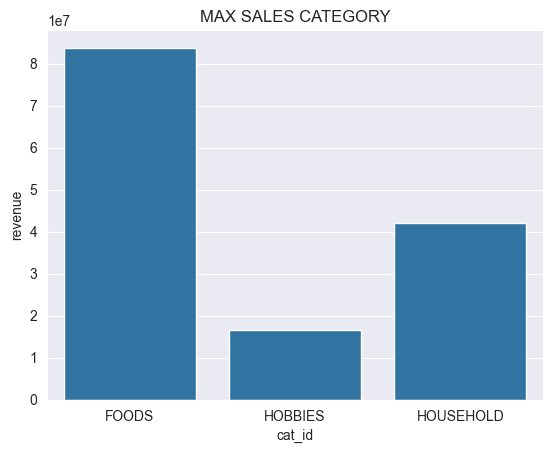

In [39]:
max_category_sales = sns.barplot(data=train_data.groupby(['cat_id'])['revenue'].sum().reset_index(),
                                 x='cat_id', y='revenue')
plt.title("MAX SALES CATEGORY")
plt.show()

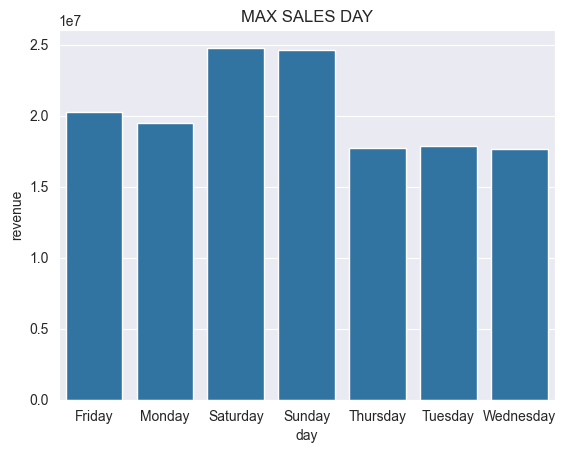

In [41]:
max_day_sales = sns.barplot(data=train_data.groupby(['day'])['revenue'].sum().reset_index(),
                                 x='day', y='revenue')
plt.title("MAX SALES DAY")
plt.show()

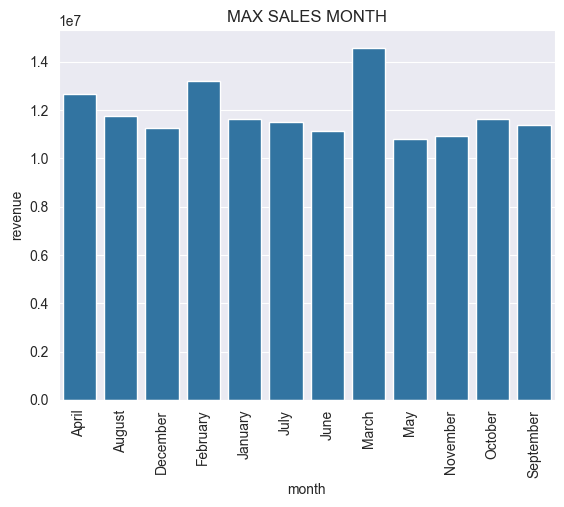

In [44]:
max_month_sales = sns.barplot(data=train_data.groupby(['month'])['revenue'].sum().reset_index(),
                                 x='month', y='revenue')
plt.title("MAX SALES MONTH")
plt.xticks(rotation=90)
plt.show()

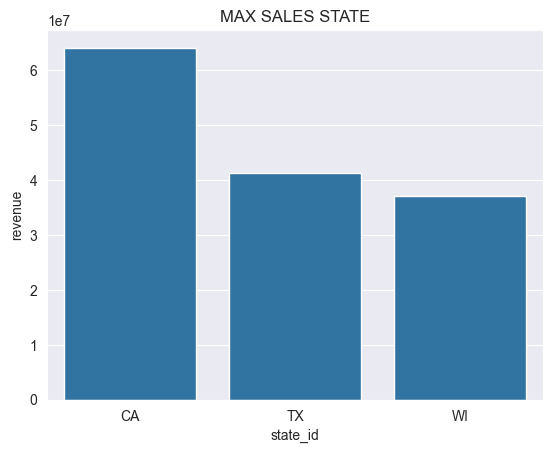

In [45]:
max_state_sales = sns.barplot(data=train_data.groupby(['state_id'])['revenue'].sum().reset_index(),
                                 x='state_id', y='revenue')
plt.title("MAX SALES STATE")
plt.show()

In [49]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46985090 entries, 0 to 46985089
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   item_id   object        
 1   cat_id    object        
 2   store_id  object        
 3   state_id  object        
 4   date      datetime64[ns]
 5   day       object        
 6   month     object        
 7   revenue   float32       
dtypes: datetime64[ns](1), float32(1), object(6)
memory usage: 2.6+ GB


In [6]:
cat_cols = ['item_id',	'cat_id', 'store_id', 'state_id', 'day', 'month']

ord_enc = make_column_transformer(
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan), cat_cols)
)

In [7]:
train_data

,item_id,cat_id,store_id,state_id,date,day,month,revenue
0,HOBBIES_1_001,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
1,HOBBIES_1_002,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
2,HOBBIES_1_003,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
3,HOBBIES_1_004,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
4,HOBBIES_1_005,HOBBIES,CA_1,CA,2011-01-29,Saturday,January,0.00
...,...,...,...,...,...,...,...,...
46985085,FOODS_3_823,FOODS,WI_3,WI,2015-04-18,Saturday,April,5.76
46985086,FOODS_3_824,FOODS,WI_3,WI,2015-04-18,Saturday,April,0.00
46985087,FOODS_3_825,FOODS,WI_3,WI,2015-04-18,Saturday,April,0.00
46985088,FOODS_3_826,FOODS,WI_3,WI,2015-04-18,Saturday,April,0.00


In [8]:
train_data.loc[:, cat_cols] = ord_enc.fit_transform(train_data[cat_cols])

In [11]:
pickle.dump(ord_enc, open("../../models/ord_enc.p", "wb"))

In [ ]:
train_data = pd.read_csv("../../data/interim/train_data_encoded.csv")

In [ ]:
train_data[cat_cols] = train_data[cat_cols].astype('int16')
train_data['revenue'] = train_data['revenue'].astype('float32')


In [11]:
train_data.to_csv('../../data/interim/train_data_cleaned_encoded.csv', index=False)

In [3]:
train_data = pd.read_csv("../../data/interim/train_data_cleaned_encoded.csv")

In [9]:
train_data = reduce_dtype(train_data)
train_data['date'] = pd.to_datetime(train_data['date'])

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46985090 entries, 0 to 46985089
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   item_id   int16         
 1   cat_id    int16         
 2   store_id  int16         
 3   state_id  int16         
 4   date      datetime64[ns]
 5   day       int16         
 6   month     int16         
 7   revenue   float32       
dtypes: datetime64[ns](1), float32(1), int16(6)
memory usage: 1.1 GB


#### MODEL PROCESSING USING XGBREGRESSOR

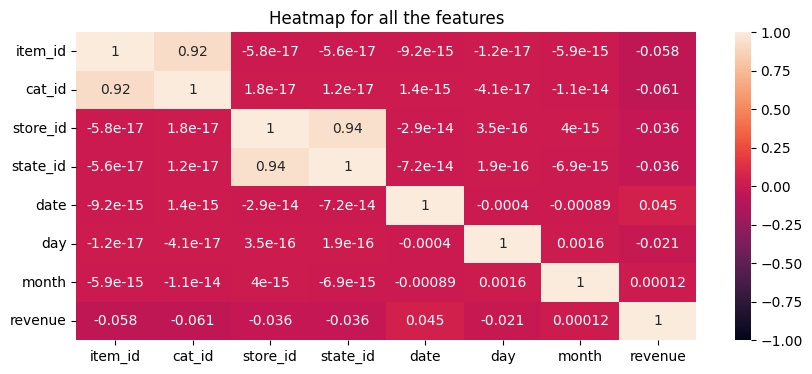

In [50]:
plt.figure(figsize=(10,4))
sns.heatmap(train_data.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Heatmap for all the features")
plt.show()

In [11]:
train_data['date'] = train_data['date'].map(dt.datetime.toordinal)
df_train = train_data[train_data['date']<='2014-01-01']
df_val = train_data[train_data['date']>'2014-01-01']

In [14]:
X_train = df_train.drop('revenue', axis=1)
X_test = df_val.drop('revenue', axis=1)
y_train = df_train[['revenue']]
y_test = df_val[['revenue']]

In [59]:
model = XGBRegressor()
model.fit(X_train, y_train)

E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
with open('../../models/predictive/xgb_regressor.p', 'rb') as f:
    model = pickle.load(f)

In [16]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\xgboost

In [49]:
predict_naive_model_scores(y_test)

MAE SCORE for Naive Model:4.380582809448242
RMSE SCORE for Naive Model:9.17113971710205
R2 SCORE for Naive Model:0.0


In [19]:
get_scores(y_train, y_pred_train, split="Train")

MAE SCORE for Train:3.9478981494903564
RMSE SCORE for Train:8.632607460021973
R2 SCORE for Train:0.07238568607413154


In [18]:
get_scores(y_test, y_pred, split="Test")

MAE SCORE for Test:4.214709281921387
RMSE SCORE for Test:9.346136093139648
R2 SCORE for Test:0.05405022540142368


In [71]:
pickle.dump(model, open("../../models/predictive/xgb_regressor.p", "wb"))

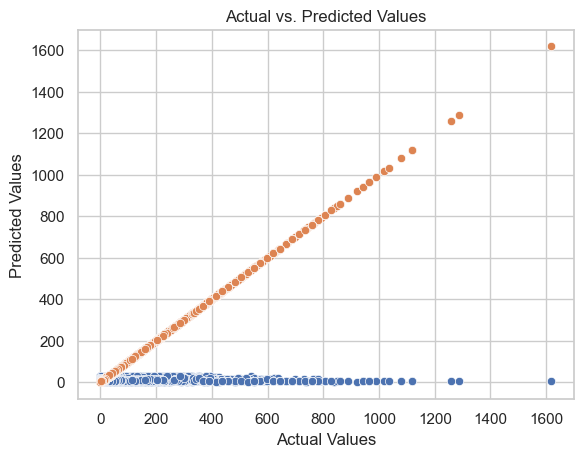

In [28]:
sns.set(style="whitegrid")

sns.scatterplot(x=y_test['revenue'], y= y_pred)
sns.scatterplot(x=y_test['revenue'], y= y_test['revenue'])

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

plt.show()

#### TESTING ON TREE MODEL

In [1]:
train_data = pd.read_csv("../../data/interim/train_data_cleaned_encoded.csv")

In [2]:
train_data = reduce_dtype(train_data)
train_data['date'] = pd.to_datetime(train_data['date'])

In [8]:
train_data['date'] = train_data['date'].map(dt.datetime.toordinal)

In [9]:
X = train_data.drop(['revenue'],axis=1)
y= train_data[['revenue']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [53]:
X_train.to_csv("../../data/processed/X_train.csv", index=False)
X_test.to_csv("../../data/processed/X_test.csv", index=False)
y_train.to_csv("../../data/processed/y_train.csv", index=False)
y_test.to_csv("../../data/processed/y_test.csv", index=False)

In [11]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [16]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
get_scores(y_train, y_pred_train, split='Train')

MAE SCORE for Train:0.0
RMSE SCORE for Train:0.0
R2 SCORE for Train:1.0


In [15]:
get_scores(y_test, y_pred, split='Test')

MAE SCORE for Test:2.919089550253608
RMSE SCORE for Test:7.506622179912124
R2 SCORE for Test:0.3300500588780061


In [18]:
pickle.dump(model, open("../../models/predictive/decision_tree.p", "wb"))

In [19]:
model = DecisionTreeRegressor(max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None
)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [20]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
get_scores(y_train, y_pred_train, split='Train')

MAE SCORE for Train:4.294479426651678
RMSE SCORE for Train:9.099919919556324
R2 SCORE for Train:0.015292885310849935


In [21]:
get_scores(y_test, y_pred, split='Test')

MAE SCORE for Test:4.296529350461857
RMSE SCORE for Test:9.100594665591116
R2 SCORE for Test:0.015325296092540741


#### Hyperparameter tuning Decision Tree Regressor model

In [118]:
param_grid_1 = {
    'max_depth': [58, 59, 60,61,62]
}
model = DecisionTreeRegressor(max_depth=10,
    min_samples_split=60,
    min_samples_leaf=18,
    max_features=None
)
grid_search = GridSearchCV(model, param_grid_1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'max_depth': 60}

In [120]:
param_grid_2 = {
    'min_samples_split': [38,39,40, 41, 42]
}
model = DecisionTreeRegressor(max_depth=60,
    min_samples_split=2,
    min_samples_leaf=18,
    max_features=None
)
grid_search = GridSearchCV(model, param_grid_2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'min_samples_split': 39}

In [25]:
param_grid_2 = {
    'max_depth': [90, 100, 110]
}
model = DecisionTreeRegressor(max_depth=60,
    min_samples_split=39,
    min_samples_leaf=18,
    max_features=None
)
grid_search = GridSearchCV(model, param_grid_2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'max_depth': 100}

In [121]:
param_grid_3 = {
    'min_samples_leaf': [15, 16, 17, 18, 19]
}
model = DecisionTreeRegressor(max_depth=60,
    min_samples_split=39,
    min_samples_leaf=18,
    max_features=None
)
grid_search = GridSearchCV(model, param_grid_3, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'min_samples_leaf': 18}

#### INITIALLY TESTING MODELS WITH NAIVE SCORES

In [40]:
predict_naive_model_scores(y_test)

MAE SCORE for Naive Model:4.380582809448242
RMSE SCORE for Naive Model:9.17113971710205
R2 SCORE for Naive Model:0.0


#### RUNNING TUNED MODEL USING DECISION TREE REGRESSOR

In [9]:
model = train_predictive_model(X_train, y_train, X_test, y_test)

MAE SCORE for Train:2.1650502509449265
RMSE SCORE for Train:5.164827679705245
R2 SCORE for Train:0.6827923830779378
MAE SCORE for Test:2.414979044865927
RMSE SCORE for Test:5.700698704841646
R2 SCORE for Test:0.6136246475967042


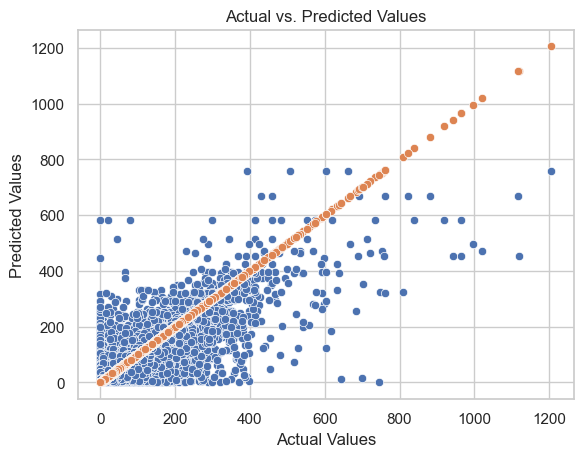

In [64]:
predict_model(model, X_train, y_train, X_test, y_test, save_model=False, save_model_file_name='decision_tree_final_model.p', plot=True)

##### DEPLOYING MODEL

In [9]:
store_id = "CA_1"
item_id = "HOBBIES_1_002"
date = '2015-03-29'
output= predict_inference_model(store_id,item_id,date)
output

[0.34521739379219385]

##### MODEL IMPORTANCE SCORE

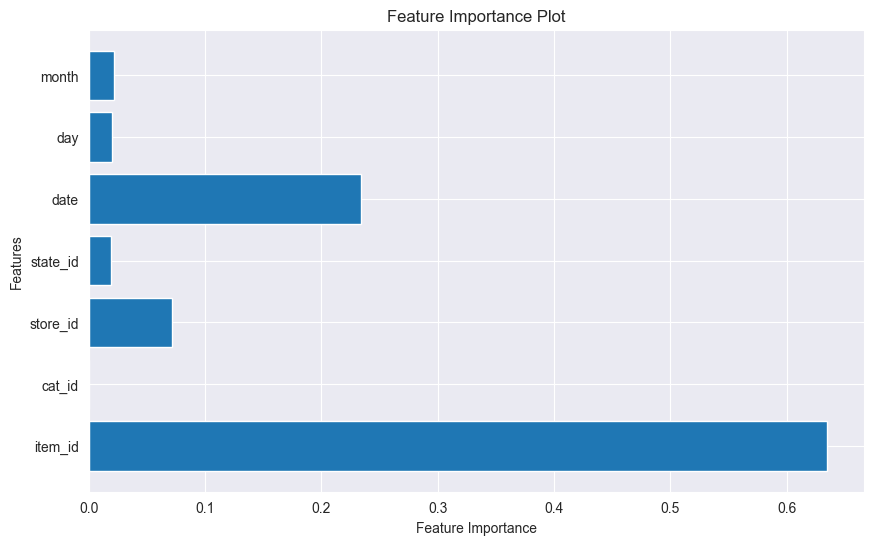

In [20]:
feature_importance_plot(model)

In [2]:
!python --version


Python 3.9.13


In [1]:
import pickle
print(pickle.format_version)

4.0
